You can read an overview of this Numerical Linear Algebra course in [this blog post](http://www.fast.ai/2017/07/17/num-lin-alg/).  The course was originally taught in the [University of San Francisco MS in Analytics](https://www.usfca.edu/arts-sciences/graduate-programs/analytics) graduate program.  Course lecture videos are [available on YouTube](https://www.youtube.com/playlist?list=PLtmWHNX-gukIc92m1K0P6bIOnZb-mg0hY) (note that the notebook numbers and video numbers do not line up, since some notebooks took longer than 1 video to cover).

You can ask questions about the course on [our fast.ai forums](http://forums.fast.ai/c/lin-alg).

# 2. Topic Modeling with NMF and SVD

Topic modeling is a great way to get started with matrix factorizations. We start with a **term-document matrix**:

<img src="images/document_term.png" alt="term-document matrix" style="width: 80%"/>
(source: [Introduction to Information Retrieval](http://player.slideplayer.com/15/4528582/#))

We can decompose this into one tall thin matrix times one wide short matrix (possibly with a diagonal matrix in between).

Notice that this representation does not take into account word order or sentence structure.  It's an example of a **bag of words** approach.

### Motivation

Consider the most extreme case - reconstructing the matrix using an outer product of two vectors. Clearly, in most cases we won't be able to reconstruct the matrix exactly. But if we had one vector with the relative frequency of each vocabulary word out of the total word count, and one with the average number of words per document, then that outer product would be as close as we can get.

Now consider increasing that matrices to two columns and two rows. The optimal decomposition would now be to cluster the documents into two groups, each of which has as different a distribution of words as possible to each other, but as similar as possible amongst the documents in the cluster. We will call those two groups "topics". And we would cluster the words into two groups, based on those which most frequently appear in each of the topics. 

### In today's class

We'll take a dataset of documents in several different categories, and find topics (consisting of groups of words) for them.  Knowing the actual categories helps us evaluate if the topics we find make sense.

We will try this with two different matrix factorizations: **Singular Value Decomposition (SVD)** and **Non-negative Matrix Factorization (NMF)**

In [17]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [18]:
%matplotlib inline
np.set_printoptions(suppress=True)

## Additional Resources

- [Data source](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html): Newsgroups are discussion groups on Usenet, which was popular in the 80s and 90s before the web really took off.  This dataset includes 18,000 newsgroups posts with 20 topics.
- [Chris Manning's book chapter](https://nlp.stanford.edu/IR-book/pdf/18lsi.pdf) on matrix factorization and LSI 
- Scikit learn [truncated SVD LSI details](http://scikit-learn.org/stable/modules/decomposition.html#lsa)

### Other Tutorials
- [Scikit-Learn: Out-of-core classification of text documents](http://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html): uses [Reuters-21578](https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection) dataset (Reuters articles labeled with ~100 categories), HashingVectorizer
- [Text Analysis with Topic Models for the Humanities and Social Sciences](https://de.dariah.eu/tatom/index.html): uses [British and French Literature dataset](https://de.dariah.eu/tatom/datasets.html) of Jane Austen, Charlotte Bronte, Victor Hugo, and more

## Set up data

Scikit Learn comes with a number of built-in datasets, as well as loading utilities to load several standard external datasets. This is a [great resource](http://scikit-learn.org/stable/datasets/), and the datasets include Boston housing prices, face images, patches of forest, diabetes, breast cancer, and more.  We will be using the newsgroups dataset.

Newsgroups are discussion groups on Usenet, which was popular in the 80s and 90s before the web really took off.  This dataset includes 18,000 newsgroups posts with 20 topics.  

In [19]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [20]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

Let's look at some of the data.  Can you guess which category these messages are in?

In [9]:
print("\n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

hint: definition of *perijove* is the point in the orbit of a satellite of Jupiter nearest the planet's center 

In [21]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'],
      dtype='<U18')

The target attribute is the integer index of the category.

In [22]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

In [23]:
num_topics, num_top_words = 6, 8

Next, scikit learn has a method that will extract all the word counts for us.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [25]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [15]:
print(len(newsgroups_train.data), vectors.shape)

(2034, (2034, 26576))


In [16]:
vocab = np.array(vectorizer.get_feature_names())

In [17]:
vocab.shape

(26576,)

In [18]:
vocab[7000:7020]

array([u'cosmonauts', u'cosmos', u'cosponsored', u'cost', u'costa',
       u'costar', u'costing', u'costly', u'costruction', u'costs', u'cosy',
       u'cote', u'couched', u'couldn', u'council', u'councils', u'counsel',
       u'counselees', u'counselor', u'count'],
      dtype='<U80')

## Singular Value Decomposition (SVD)

"SVD is not nearly as famous as it should be." - Gilbert Strang

We would clearly expect that the words that appear most frequently in one topic would appear less frequently in the other - otherwise that word wouldn't make a good choice to separate out the two topics. Therefore, we expect the topics to be **orthogonal**.

The SVD algorithm factorizes a matrix into one matrix with **orthogonal columns** and one with **orthogonal rows** (along with a diagonal matrix, which contains the **relative importance** of each factor).

矩阵A：row是words，column是documents；

矩阵U：row是words，column是topics；

矩阵V：row是topics，column是documents；


<img src="images/svd_fb.png" alt="" style="width: 80%"/>
(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

SVD is an **exact decomposition**, since the matrices it creates are big enough to fully cover the original matrix. SVD is extremely widely used in linear algebra, and specifically in data science, including:

- semantic analysis
- collaborative filtering/recommendations ([winning entry for Netflix Prize](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf))
- calculate Moore-Penrose pseudoinverse
- data compression
- principal component analysis (will be covered later in course)

In [22]:
# %time 计算某条语句的运行时间 very handy
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 2min 54s, sys: 3min 37s, total: 6min 31s
Wall time: 32.3 s


In [23]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


Confirm this is a decomposition of the input.

#### Answer

In [28]:
#Exercise: confrim that U, s, Vh is a decomposition of the var Vectors
reconstructed_vectors = U @ np.diag(s) @ Vh
# print(reconstructed_vectors.shape)

# 矩阵的norm，就是拉成一个长向量，然后计算向量的norm，在这里norm用于计算两个矩阵的距离
np.linalg.norm(reconstructed_vectors - vectors) 

# 判断两个矩阵是否可以视为相等
np.allclose(reconstructed_vectors, vectors)

True

Confirm that U, V are orthonormal

#### Answer

In [33]:
#Exercise: Confirm that U, Vh are orthonormal
# U的column是orthonormal， Vh的row是orthonormal，则 UTU=I, VVT=I
np.allclose(U.T @ U, np.eye(U.shape[1]))
np.allclose(Vh @ Vh.T, np.eye(Vh.shape[0]))


True

#### Topics

What can we say about the singular values s?

eigenvalue的值下降得很快，说明前几个eigenvalue占据大半壁江山

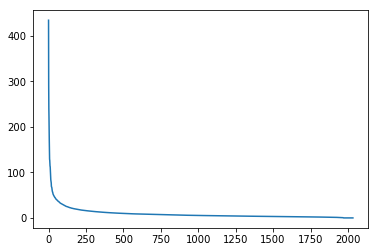

In [96]:
plt.plot(s);

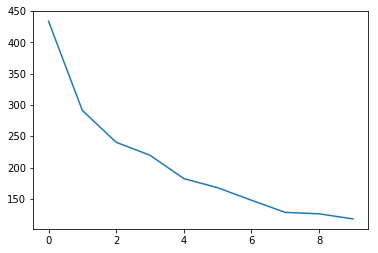

In [97]:
plt.plot(s[:10])

In [ ]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    # t.shape = (26576, )
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

'''
>>> x = np.array([3, 1, 2])
>>> np.argsort(x)
array([1, 2, 0])

np.argsort(t)[:-num_top_words-1:-1]] 相当于去取了bag of word里面频率最高的10个词的index
'''


In [ ]:
Vh[:10].shape

In [45]:
show_topics(Vh[:10])

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

We get topics that match the kinds of clusters we would expect! This is despite the fact that this is an **unsupervised algorithm** - which is to say, we never actually told the algorithm how our documents are grouped.

We will return to SVD in **much more detail** later.  For now, the important takeaway is that we have a tool that allows us to exactly factor a matrix into orthogonal columns and orthogonal rows.

## Non-negative Matrix Factorization (NMF)

#### Motivation

<img src="images/face_pca.png" alt="PCA on faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

A more interpretable approach:

<img src="images/face_outputs.png" alt="NMF on Faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

#### Idea

Rather than constraining our factors to be *orthogonal*, another idea would to constrain them to be *non-negative*. NMF is a factorization of a non-negative data set $V$: $$ V = W H$$ into non-negative matrices $W,\; H$. Often positive factors will be **more easily interpretable** (and this is the reason behind NMF's popularity). 

<img src="images/face_nmf.png" alt="NMF on faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

将V分解为两个矩阵W和H，只要W和H的entries都是non-negative的就好，不需要是orthogonal的。

矩阵V的Column是一张张face的图片

Nonnegative matrix factorization (NMF) is a non-exact factorization that factors into one skinny positive matrix and one short positive matrix.  NMF is NP-hard and non-unique.  There are a number of variations on it, created by adding different constraints. 

#### Applications of NMF

- [Face Decompositions](http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py)
- [Collaborative Filtering, eg movie recommendations](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/)
- [Audio source separation](https://pdfs.semanticscholar.org/cc88/0b24791349df39c5d9b8c352911a0417df34.pdf)
- [Chemistry](http://ieeexplore.ieee.org/document/1532909/)
- [Bioinformatics](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-015-0485-4) and [Gene Expression](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2623306/)
- Topic Modeling (our problem!)

<img src="images/nmf_doc.png" alt="NMF on documents" style="width: 80%"/>

矩阵H的column代表 for each document，it's relative importance for each topic

因此矩阵W的row很明显代表topic，H的column对W的row进行一个加权，最终得到该document所属的topic

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

**More Reading**:

- [The Why and How of Nonnegative Matrix Factorization](https://arxiv.org/pdf/1401.5226.pdf)

### NMF from sklearn

First, we will use [scikit-learn's implementation of NMF](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html):

In [27]:
m,n=vectors.shape
d=5  # num topics

In [28]:
# n_components=5 代表5个topic
clf = decomposition.NMF(n_components=d, random_state=1)

# W1 @ H1 只是对原矩阵的一个approximate
W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [29]:
print(W1.shape)
print(H1.shape)

(2034, 5)
(5, 26576)


In [30]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

### TF-IDF

[Topic Frequency-Inverse Document Frequency](http://www.tfidf.com/) (TF-IDF) is a way to normalize term counts by taking into account how often they appear in a document, how long the document is, and how commmon/rare the term is.

TF = (# occurrences of term t in document) / (# of words in documents)

IDF = log(# of documents / # documents with term t in it)

>IDF measures how rare a word is. If a word only shows up in some kind of documents, it's very important for this topic.

In [31]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [32]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [33]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

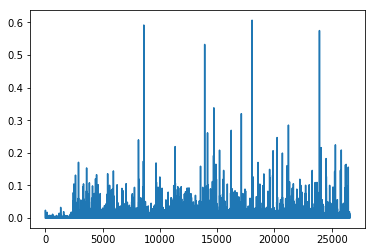

In [26]:
plt.plot(clf.components_[0])

In [27]:
clf.reconstruction_err_

43.71292605795277

### NMF in summary

Benefits: Fast and easy to use!

Downsides: took years of research and expertise to create

Notes:
- For NMF, matrix needs to be at least as tall as it is wide, or we get an error with fit_transform
- Can use df_min in CountVectorizer to only look at words that were in at least k of the split texts

### NMF from scratch in numpy, using SGD

#### Gradient Descent

The key idea of standard **gradient descent**:
1. Randomly choose some weights to start
2. Loop:
    - Use weights to calculate a prediction
    - Calculate the derivative of the loss
    - Update the weights
3. Repeat step 2 lots of times.  Eventually we end up with some decent weights.

**Key**: We want to decrease our loss and the derivative tells us the direction of **steepest descent**.  

Note that *loss*, *error*, and *cost* are all terms used to describe the same thing.

Let's take a look at the [Gradient Descent Intro notebook](gradient-descent-intro.ipynb) (originally from the [fast.ai deep learning course](https://github.com/fastai/courses)).

#### Stochastic Gradient Descent (SGD)

**Stochastic gradient descent** is an incredibly useful optimization method (it is also the heart of deep learning, where it is used for backpropagation).

For *standard* gradient descent, we evaluate the loss using **all** of our data which can be really slow.  In *stochastic* gradient descent, we evaluate our loss function on just a sample of our data (sometimes called a **mini-batch**).  We would get different loss values on different samples of the data, so this is *why it is stochastic*.  It turns out that this is still an effective way to optimize, and it's much more efficient!

We can see how this works in this [excel spreadsheet](graddesc.xlsm) (originally from the [fast.ai deep learning course](https://github.com/fastai/courses)).

**Resources**:
- [SGD Lecture from Andrew Ng's Coursera ML course](https://www.coursera.org/learn/machine-learning/lecture/DoRHJ/stochastic-gradient-descent)
- <a href="http://wiki.fast.ai/index.php/Stochastic_Gradient_Descent_(SGD)">fast.ai wiki page on SGD</a>
- [Gradient Descent For Machine Learning](http://machinelearningmastery.com/gradient-descent-for-machine-learning/) (Jason Brownlee- Machine Learning Mastery)
- [An overview of gradient descent optimization algorithms](http://sebastianruder.com/optimizing-gradient-descent/)

#### Applying SGD to NMF

**Goal**: Decompose $V\;(m \times n)$ into $$V \approx WH$$ where $W\;(m \times d)$ and $H\;(d \times n)$, $W,\;H\;>=\;0$, and we've minimized the Frobenius norm of $V-WH$.

**Approach**: We will pick random positive $W$ & $H$, and then use SGD to optimize.

**To use SGD, we need to know the gradient of the loss function.**

**Sources**:
- Optimality and gradients of NMF: http://users.wfu.edu/plemmons/papers/chu_ple.pdf
- Projected gradients: https://www.csie.ntu.edu.tw/~cjlin/papers/pgradnmf.pdf


![](http://upload-images.jianshu.io/upload_images/1791718-e445d1cbf225adbd.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

![](http://upload-images.jianshu.io/upload_images/1791718-388fe122c86047c5.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

In [57]:
lam=1e3
lr=1e-2
m, n = vectors_tfidf.shape

In [58]:
W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [59]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

In [60]:
mu = 1e-6
def grads(M, W, H):
    R = W@H-M
    return R@H.T + penalty(W, mu)*lam, W.T@R + penalty(H, mu)*lam # dW, dH


grads这样设计是因为NMF的目标有两个：
 - $WH ≈ M$
 - $W$ and $H$ 都是 positive

`penalty` 是惩罚项，惩罚 when W and H are negative，kind of force them to learn to be positive。

loss $R$ 对 $W$ 求导结果 `dH = W.T@R` 的推导可以从维度的角度考虑：`dw.shape = (mxn)@(nxd) = mxd = W.shape`

![](http://upload-images.jianshu.io/upload_images/1791718-2aeb86b7067924d1.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)


In [61]:
def penalty(M, mu):
    return np.where(M>=mu,0, np.min(M - mu, 0))

'''
>>> np.where(x < 5, x, -1)               # Note: broadcasting.
array([[ 0.,  1.,  2.],
       [ 3.,  4., -1.],
       [-1., -1., -1.]])
       
所以M中entries>μ的，惩罚项为0，否则惩罚项为M-μ
'''

In [267]:
def upd(M, W, H, lr):
    dW,dH = grads(M,W,H)
    W -= lr*dW; H -= lr*dH

In [268]:
def report(M,W,H): 
    print(np.linalg.norm(M-W@H), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [348]:
W = np.abs(np.random.normal(scale=0.01, size=(m,d)))
H = np.abs(np.random.normal(scale=0.01, size=(d,n)))

In [349]:
report(vectors_tfidf, W, H)

44.4395133509 5.67503308167e-07 2.49717354504e-07 0 0


In [350]:
upd(vectors_tfidf,W,H,lr)

In [351]:
report(vectors_tfidf, W, H)

44.4194155587 -0.00186845669883 -0.000182969569359 509 788


In [352]:
for i in range(50): 
    upd(vectors_tfidf,W,H,lr)
    if i % 10 == 0: report(vectors_tfidf,W,H)

44.4071645597 -0.00145791197281 -0.00012862260312 343 1174
44.352156176 -0.000549676823494 -9.16363641124e-05 218 4689
44.3020593384 -0.000284017335617 -0.000130903875061 165 9685
44.2468609535 -0.000279317810433 -0.000182173029912 169 16735
44.199218 -0.000290092649623 -0.000198140867356 222 25109


negative entries的count增加了：222。因此可以考虑increase penalty惩罚项。

In [281]:
show_topics(H)

['cview file image edu files use directory temp',
 'moral like time does don software new years',
 'god jesus bible believe objective exist atheism belief',
 'thanks graphics program know help looking windows advance',
 'space nasa launch shuttle orbit station moon lunar',
 'people don said think ico tek bobbe bronx']

This is painfully slow to train!  Lots of parameter fiddling and still slow to train (or explodes).

### PyTorch

[PyTorch](http://pytorch.org/) is a Python framework for tensors and dynamic neural networks with GPU acceleration.  Many of the core contributors work on Facebook's AI team.  In many ways, it is similar to Numpy, only with the increased parallelization of using a GPU.

From the [PyTorch documentation](http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html):

<img src="images/what_is_pytorch.png" alt="pytorch" style="width: 80%"/>

**Further learning**: If you are curious to learn what *dynamic* neural networks are, you may want to watch [this talk](https://www.youtube.com/watch?v=Z15cBAuY7Sc) by Soumith Chintala, Facebook AI researcher and core PyTorch contributor.

If you want to learn more PyTorch, you can try this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or this [learning by examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

**Note about GPUs**: If you are not using a GPU, you will need to remove the `.cuda()` from the methods below. GPU usage is not required for this course, but I thought it would be of interest to some of you.  To learn how to create an AWS instance with a GPU, you can watch the [fast.ai setup lesson](http://course.fast.ai/lessons/aws.html).

In [34]:
import torch
import torch.cuda as tc
from torch.autograd import Variable

In [35]:
def V(M): return Variable(M, requires_grad=True)

In [36]:
v=vectors_tfidf.todense()

In [37]:
t_vectors = torch.Tensor(v.astype(np.float32)).cuda()

In [38]:
mu = 1e-5

PyTorch中用 `.mm()` 代表matrix multiply矩阵乘法操作，instead of `@` in Python3.

torch.clamp()会把input的value cut it off with max or min.

`W.sub_(lr*dW)` 中 `.sub_` 等价于 `W -= ` 

In [40]:
def grads_t(M, W, H):
    R = W.mm(H)-M
    return (R.mm(H.t()) + penalty_t(W, mu)*lam, 
        W.t().mm(R) + penalty_t(H, mu)*lam) # dW, dH

def penalty_t(M, mu):
    return (M<mu).type(tc.FloatTensor)*torch.clamp(M - mu, max=0.)

def upd_t(M, W, H, lr):
    dW,dH = grads_t(M,W,H)
    W.sub_(lr*dW); H.sub_(lr*dH)

def report_t(M,W,H): 
    print((M-W.mm(H)).norm(2), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [41]:
t_W = tc.FloatTensor(m,d)
t_H = tc.FloatTensor(d,n)
t_W.normal_(std=0.01).abs_(); 
t_H.normal_(std=0.01).abs_();

In [42]:
d=6; lam=100; lr=0.05

In [43]:
for i in range(1000): 
    upd_t(t_vectors,t_W,t_H,lr)
    if i % 100 == 0: 
        report_t(t_vectors,t_W,t_H)
        lr *= 0.9

44.39408874511719 -0.005239442922174931 -0.00045824938570149243 804 1374
43.72853088378906 -0.008939008228480816 -0.007862959988415241 1395 14933
43.713932037353516 -0.005457724444568157 -0.008529571816325188 1831 17300
43.71353530883789 -0.004537038505077362 -0.007464727386832237 1867 17028
43.71295166015625 -0.005592645145952702 -0.009083676151931286 1992 17245
43.712608337402344 -0.0040139807388186455 -0.009261811152100563 2421 18885
43.71229553222656 -0.0027860980480909348 -0.007653357926756144 2577 19338
43.712120056152344 -0.0035391580313444138 -0.005246617365628481 2501 20440
43.71200942993164 -0.0037154245655983686 -0.00706232525408268 2392 20768
43.71175765991211 -0.004078149329870939 -0.006446489132940769 3156 28373


In [291]:
show_topics(t_H.cpu().numpy())

['objective morality values moral subjective science absolute claim',
 'god jesus bible believe atheism christian does belief',
 'ico bobbe tek bronx beauchaine manhattan sank queens',
 'thanks graphics files image file program windows know',
 'space nasa launch shuttle orbit lunar moon earth',
 'don people just think like know say religion']

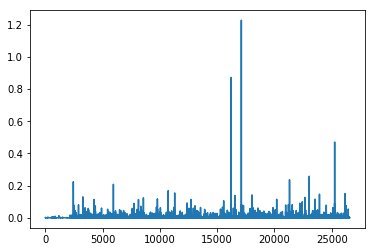

In [292]:
plt.plot(t_H.cpu().numpy()[0])

In [44]:
t_W.mm(t_H).max()

0.3979429006576538

In [45]:
t_vectors.max()

1.0

### PyTorch: autograd

Above, we used our knowledge of what the gradient of the loss function was to do SGD from scratch in PyTorch.  However, PyTorch has an automatic differentiation package, [autograd](http://pytorch.org/docs/autograd.html) which we could use instead.  This is really useful, in that we can use autograd on problems where we don't know what the derivative is.  

The approach we use below is very general, and would work for almost any optimization problem.

In PyTorch, Variables have the same API as tensors, but Variables remember the operations used on to create them.  This lets us take derivatives.

#### PyTorch Autograd Introduction

Example taken from [this tutorial](http://pytorch.org/tutorials/beginner/former_torchies/autograd_tutorial.html) in the official documentation.

In [58]:
x = Variable(torch.ones(2, 2), requires_grad=True)
print(x)

Variable containing:
 1  1
 1  1
[torch.FloatTensor of size 2x2]



In [59]:
print(x.data)


 1  1
 1  1
[torch.FloatTensor of size 2x2]



In [60]:
print(x.grad)

None


In [61]:
y = x + 2
print(y)

Variable containing:
 3  3
 3  3
[torch.FloatTensor of size 2x2]



In [62]:
z = y * y * 3
out = z.sum()
print(z, out)

Variable containing:
 27  27
 27  27
[torch.FloatTensor of size 2x2]
 Variable containing:
 108
[torch.FloatTensor of size 1]



In [63]:
out.backward()
print(x.grad)  # 6(x+2)

Variable containing:
 18  18
 18  18
[torch.FloatTensor of size 2x2]



#### Using Autograd for NMF

In [64]:
lam=1e6

In [65]:
pW = Variable(tc.FloatTensor(m,d), requires_grad=True)
pH = Variable(tc.FloatTensor(d,n), requires_grad=True)
pW.data.normal_(std=0.01).abs_()
pH.data.normal_(std=0.01).abs_();

In [66]:
def report():
    W,H = pW.data, pH.data
    print((M-pW.mm(pH)).norm(2).data[0], W.min(), H.min(), (W<0).sum(), (H<0).sum())

# increase了penalty
def penalty(A):
    return torch.pow((A<0).type(tc.FloatTensor)*torch.clamp(A, max=0.), 2)

def penalize(): return penalty(pW).mean() + penalty(pH).mean()

def loss(): return (M-pW.mm(pH)).norm(2) + penalize()*lam

In [67]:
M = Variable(t_vectors).cuda()

In [70]:
print(M.data.shape)

torch.Size([2034, 26576])


In [71]:
opt = torch.optim.Adam([pW,pH], lr=1e-3, betas=(0.9,0.9))
lr = 0.05
report()

44.439910888671875 9.823488653637469e-07 2.8387267647644876e-08 0 0


How to apply SGD, using autograd:

In [72]:
for i in range(1000): 
    # Clears the gradients of all optimized 
    opt.zero_grad()
    l = loss()
    l.backward()
    opt.step()
    if i % 100 == 99: 
        report()
        lr *= 0.9     # learning rate annealling

43.975826263427734 -0.000925424334127456 -0.0013899592449888587 230 11952
43.804752349853516 -0.0006444362225010991 -0.0007695560343563557 274 13753
43.74149703979492 -0.0008762195939198136 -0.0012977182632312179 232 13986
43.70267868041992 -0.0003551738627720624 -0.0011412897147238255 223 12840
43.68762969970703 -0.00027323447284288704 -0.0010745191248133779 249 11906
43.67770767211914 -0.00026733518461696804 -0.0010188663145527244 225 11481
43.66156768798828 -0.0003247495915275067 -0.0008737227180972695 217 11314
43.65229797363281 -0.00027836038498207927 -0.0007515215547755361 207 11034
43.650814056396484 -0.00025301112327724695 -0.0006062831380404532 263 10443
43.650814056396484 -0.00026923269615508616 -0.0005401293747127056 280 9292


In [362]:
h = pH.data.cpu().numpy()
show_topics(h)

['god jesus bible believe atheism christian belief does',
 'thanks graphics files image file windows program format',
 'just don think people like ve graphics religion',
 'objective morality values moral subjective science absolute claim',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'space nasa shuttle launch orbit lunar moon data']

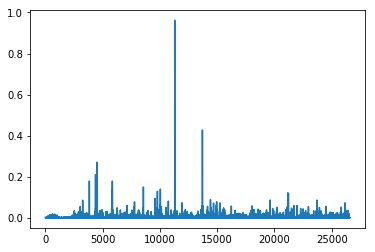

In [174]:
plt.plot(h[0]);

### Comparing Approaches

#### Scikit-Learn's NMF
- Fast
- No parameter tuning
- Relies on decades of academic research, took experts a long time to implement

<img src="images/nimfa.png" alt="research on NMF" style="width: 80%"/>
source: [Python Nimfa Documentation](http://nimfa.biolab.si/)

#### Using PyTorch and SGD
- Took us an hour to implement, didn't have to be NMF experts
- Parameters were fiddly
- Not as fast (tried in numpy and was so slow we had to switch to PyTorch)

## Truncated SVD

We saved a lot of time when we calculated NMF by only calculating the subset of columns we were interested in. Is there a way to get this benefit with SVD? Yes there is! It's called truncated SVD.  We are just interested in the vectors corresponding to the **largest** singular values.

<img src="images/svd_fb.png" alt="" style="width: 80%"/>
(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

#### Shortcomings of classical algorithms for decomposition:

- Matrices are "stupendously big"
- Data are often **missing or inaccurate**.  Why spend extra computational resources when imprecision of input limits precision of the output?
- **Data transfer** now plays a major role in time of algorithms.  Techniques the require fewer passes over the data may be substantially faster, even if they require more flops (flops = floating point operations).
- Important to take advantage of **GPUs**.

(source: [Halko](https://arxiv.org/abs/0909.4061))

## New Perspective on SVD & NMF

- 矩阵 $X$ 可以看成是 $x$ 对column的linear combination

![](http://upload-images.jianshu.io/upload_images/1791718-cfcf6a428cc7e017.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

- 矩阵的乘法可以看作是对矩阵A做linear combination
![](http://upload-images.jianshu.io/upload_images/1791718-63d45b9c91983f50.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

### SVD
以一个实际的例子来看看SVD到底啥意思。
wuli 矩阵 $A$ 长这样，row代表某document，column代表64 top words的tf-idf：

| A                   | adams    | allworthy | bounderby | brandon  | catherine   | cathy    | corporal | crawley  | darcy   | dashwood | did      | earnshaw | edgar    | elinor   | emma     | father   | ferrars  | finn     | glegg    | good     | gradgrind | hareton  | heathcliff | jennings | jones    | joseph   | know     | lady     | laura    | like     | linton   | little   | ll       | lopez    | louisa   | lyndon   | maggie   | man      | marianne | miss     | mr       | mrs      | old      | osborne  | pendennis   | philip   | phineas  | quoth    | said     | sissy    | sophia   | sparsit  | stephen  | thought  | time     | tis      | toby     | tom      | trim     | tulliver | uncle    | wakem    | wharton  | willoughby |
| ------------------- | -------- | --------- | --------- | -------- | ----------- | -------- | -------- | -------- | ------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | --------- | -------- | ---------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | ----------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | ---------- |
| Sterne_Tristram     | 0        | 0         | 0         | 0        | 0           | 0        | 0.154664 | 0        | 0       | 0        | 0.04909  | 0        | 0        | 0        | 0        | 0.184243 | 0        | 0        | 0        | 0.056896 | 0         | 0        | 0          | 0        | 0        | 0.001043 | 0.040875 | 0.005957 | 0        | 0.050323 | 0        | 0.053815 | 0.023416 | 0        | 0        | 0        | 0        | 0.089965 | 0        | 0.000851 | 0.010681 | 0.021713 | 0.017664 | 0        | 0           | 0.000522 | 0        | 0.141643 | 0.170482 | 0        | 0        | 0        | 0        | 0.021362 | 0.070041 | 0.105531 | 0.755171 | 0.009257 | 0.126161 | 0        | 0.224577 | 0        | 0.000522 | 0          |
| Austen_Pride        | 0        | 0         | 0         | 0        | 0.067989879 | 0        | 0        | 0        | 0.48246 | 0        | 0.086367 | 0        | 0        | 0        | 0        | 0.043024 | 0        | 0        | 0        | 0.064058 | 0         | 0        | 0          | 0        | 0.002588 | 0        | 0.075531 | 0.060871 | 0        | 0.02454  | 0        | 0.060234 | 0.00033  | 0        | 0.003699 | 0        | 0        | 0.048123 | 0        | 0.093472 | 0.250178 | 0.113289 | 0.004143 | 0        | 0           | 0        | 0        | 0        | 0.127798 | 0        | 0        | 0        | 0        | 0.035694 | 0.064696 | 0.001231 | 0        | 0        | 0.00046  | 0        | 0.02279  | 0        | 0        | 0          |
| Thackeray_Pendennis | 0        | 0         | 0         | 0        | 0.001074284 | 0        | 0.000515 | 0.001641 | 0       | 0        | 0.074362 | 0        | 0        | 0        | 0.000908 | 0.029948 | 0        | 0.000374 | 0        | 0.103802 | 0         | 0        | 0          | 0        | 0.002267 | 0.000215 | 0.070809 | 0.101265 | 0.159033 | 0.069921 | 0.001121 | 0.125121 | 0.037876 | 0        | 0.000245 | 0        | 0        | 0.114335 | 0        | 0.086535 | 0.18857  | 0.078513 | 0.122964 | 0        | 0.391460539 | 0        | 0        | 0        | 0.241233 | 0        | 0        | 0        | 0        | 0.052409 | 0.055201 | 0.001471 | 0        | 0.007026 | 0.001464 | 0        | 0.025382 | 0        | 0        | 0          |
| ABronte_Agnes       | 0        | 0         | 0         | 0        | 0           | 0        | 0        | 0        | 0       | 0        | 0.138309 | 0        | 0        | 0        | 0        | 0.053506 | 0        | 0        | 0        | 0.119127 | 0         | 0        | 0          | 0        | 0        | 0.001709 | 0.121147 | 0.057545 | 0        | 0.140328 | 0        | 0.190806 | 0.039758 | 0        | 0        | 0        | 0        | 0.049468 | 0        | 0.190421 | 0.157491 | 0.040805 | 0.069659 | 0        | 0           | 0        | 0        | 0        | 0.187777 | 0        | 0        | 0        | 0        | 0.096917 | 0.150424 | 0.0013   | 0        | 0.0416   | 0.001456 | 0        | 0.010463 | 0        | 0        | 0          |
| Austen_Sense        | 0        | 0         | 0         | 0.145879 | 0           | 0        | 0        | 0        | 0       | 0.255289 | 0.068761 | 0        | 0        | 0.616621 | 0        | 0.008351 | 0.131697 | 0        | 0        | 0.049274 | 0         | 0        | 0          | 0.233002 | 0        | 0        | 0.064585 | 0.03953  | 0        | 0.023106 | 0        | 0.044541 | 0.000866 | 0        | 0        | 0        | 0        | 0.033684 | 0.429012 | 0.060586 | 0.049552 | 0.152909 | 0.012249 | 0        | 0           | 0        | 0        | 0        | 0.110518 | 0        | 0.001329 | 0        | 0        | 0.032292 | 0.066534 | 0.002151 | 0        | 0        | 0.000401 | 0        | 0.004905 | 0        | 0        | 0.17714    |
| Thackeray_Vanity    | 0        | 0         | 0         | 0        | 0.000228652 | 0        | 0.002193 | 0.456333 | 0       | 0        | 0.066577 | 0        | 0        | 0        | 0.000322 | 0.04335  | 0        | 0        | 0        | 0.084944 | 0         | 0        | 0          | 0        | 0.003729 | 0.023323 | 0.046726 | 0.10358  | 0.001442 | 0.048751 | 0.000398 | 0.151926 | 0.019874 | 0        | 0.000784 | 0        | 0        | 0.067523 | 0.000368 | 0.147235 | 0.106821 | 0.114765 | 0.123972 | 0.274237 | 0           | 0.000686 | 0        | 0        | 0.181501 | 0        | 0.000322 | 0        | 0        | 0.050912 | 0.046051 | 0.001043 | 0        | 0.005912 | 0.001947 | 0        | 0.003079 | 0        | 0        | 0          |
| Trollope_Barchester | 0        | 0         | 0         | 0        | 0           | 0        | 0.000369 | 0        | 0       | 0        | 0.10872  | 0        | 0        | 0        | 0        | 0.049997 | 0        | 0        | 0        | 0.050178 | 0         | 0        | 0          | 0        | 0.001181 | 0        | 0.057269 | 0.03727  | 0        | 0.030362 | 0        | 0.059996 | 0.023364 | 0        | 0        | 0        | 0        | 0.096539 | 0        | 0.039945 | 0.388155 | 0.142821 | 0.041088 | 0        | 0           | 0        | 0        | 0        | 0.233984 | 0        | 0        | 0        | 0        | 0.04727  | 0.035998 | 0.000702 | 0        | 0.00398  | 0.000786 | 0        | 0.000188 | 0        | 0        | 0          |
| Fielding_Tom        | 0.000434 | 0.347432  | 0         | 0        | 0.00026991  | 0        | 0.000971 | 0        | 0       | 0        | 0.080504 | 0        | 0        | 0        | 0        | 0.047186 | 0        | 0        | 0        | 0.118763 | 0         | 0        | 0          | 0        | 0.419696 | 0        | 0.075403 | 0.114459 | 0        | 0.038578 | 0        | 0.102343 | 0.009252 | 0        | 0        | 0        | 0        | 0.114618 | 0        | 0.019164 | 0.194006 | 0.104578 | 0.025347 | 0.000515 | 0           | 0        | 0        | 0.006467 | 0.15208  | 0        | 0.342367 | 0        | 0        | 0.049259 | 0.084011 | 0.003079 | 0        | 0.031817 | 0        | 0        | 0.014043 | 0        | 0        | 0.00047    |
| Dickens_Bleak       | 0        | 0         | 0         | 0        | 0           | 0        | 0        | 0        | 0       | 0        | 0.05547  | 0        | 0        | 0        | 0.004773 | 0.019201 | 0        | 0        | 0        | 0.086405 | 0         | 0        | 0          | 0        | 0.000866 | 0        | 0.119074 | 0.098539 | 0.001139 | 0.085205 | 0        | 0.153609 | 0.030264 | 0        | 0        | 0        | 0        | 0.083872 | 0        | 0.079321 | 0.412558 | 0.093417 | 0.102006 | 0        | 0           | 0        | 0        | 0.001708 | 0.232414 | 0        | 0        | 0        | 0        | 0.046136 | 0.088405 | 0.001545 | 0        | 0.013049 | 0.000769 | 0        | 0.001106 | 0        | 0        | 0          |
| Eliot_Mill          | 0        | 0         | 0         | 0        | 0           | 0        | 0        | 0        | 0       | 0        | 0.03488  | 0        | 0        | 0        | 0        | 0.060763 | 0        | 0        | 0.185358 | 0.048168 | 0         | 0        | 0          | 0        | 0        | 0        | 0.056611 | 0.008305 | 0.00266  | 0.076265 | 0        | 0.055503 | 0.050637 | 0        | 0.000268 | 0        | 0.706176 | 0.040832 | 0        | 0.022234 | 0.128724 | 0.08406  | 0.030312 | 0        | 0           | 0.157882 | 0        | 0        | 0.228104 | 0        | 0.00033  | 0        | 0.106653 | 0.045676 | 0.035295 | 0        | 0.000448 | 0.217086 | 0        | 0.361651 | 0.020082 | 0.112323 | 0        | 0          |
| EBronte_Wuthering   | 0        | 0         | 0         | 0        | 0.222505091 | 0.155236 | 0        | 0        | 0       | 0        | 0.082908 | 0.163999 | 0.145221 | 0        | 0        | 0.04369  | 0        | 0        | 0        | 0.04025  | 0         | 0.224091 | 0.595906   | 0        | 0        | 0.081546 | 0.042314 | 0.024081 | 0        | 0.053667 | 0.41146  | 0.061235 | 0.131916 | 0        | 0        | 0        | 0        | 0.031306 | 0        | 0.046705 | 0.107334 | 0.047418 | 0.02821  | 0        | 0           | 0        | 0        | 0        | 0.129007 | 0        | 0        | 0        | 0        | 0.040594 | 0.04369  | 0        | 0        | 0        | 0.000496 | 0        | 0.00927  | 0        | 0        | 0          |
| Eliot_Middlemarch   | 0        | 0         | 0         | 0        | 0.000205004 | 0        | 0        | 0        | 0       | 0        | 0.064293 | 0        | 0        | 0.003524 | 0        | 0.022521 | 0        | 0        | 0        | 0.074827 | 0         | 0        | 0          | 0        | 0        | 0.00123  | 0.084997 | 0.012834 | 0.000259 | 0.083786 | 0        | 0.075674 | 0.013552 | 0        | 0.002108 | 0        | 0        | 0.083786 | 0        | 0.019575 | 0.240099 | 0.087837 | 0.038866 | 0        | 0           | 0        | 0        | 0        | 0.277512 | 0        | 0.000289 | 0        | 0        | 0.0494   | 0.047705 | 0.000312 | 0        | 0.001247 | 0.000175 | 0        | 0.019199 | 0        | 0        | 0.000357   |
| Fielding_Joseph     | 0.661414 | 0.001127  | 0         | 0        | 0           | 0        | 0        | 0        | 0       | 0        | 0.075629 | 0        | 0        | 0        | 0        | 0.01882  | 0        | 0        | 0        | 0.086433 | 0         | 0        | 0          | 0        | 0.000566 | 0.319243 | 0.050536 | 0.109784 | 0        | 0.036943 | 0        | 0.08957  | 0.007224 | 0        | 0.000674 | 0        | 0        | 0.103859 | 0.000949 | 0.006502 | 0.113967 | 0.044427 | 0.020563 | 0        | 0           | 0        | 0        | 0.009673 | 0.129302 | 0        | 0.000832 | 0        | 0        | 0.036943 | 0.058203 | 0.001795 | 0        | 0.004039 | 0        | 0        | 0.000361 | 0        | 0        | 0          |
| ABronte_Tenant      | 0        | 0         | 0         | 0        | 0           | 0        | 0        | 0        | 0       | 0        | 0.144772 | 0        | 0        | 0        | 0        | 0.032717 | 0        | 0        | 0        | 0.103058 | 0         | 0        | 0          | 0        | 0        | 0        | 0.14927  | 0.05521  | 0        | 0.099377 | 0        | 0.147225 | 0.07968  | 0        | 0        | 0        | 0        | 0.064616 | 0        | 0.03433  | 0.148452 | 0.094938 | 0.04703  | 0        | 0           | 0        | 0        | 0        | 0.281364 | 0        | 0        | 0        | 0        | 0.080156 | 0.121052 | 0        | 0        | 0.000527 | 0.00059  | 0        | 0.020344 | 0        | 0        | 0          |
| Austen_Emma         | 0        | 0         | 0         | 0        | 0.000372779 | 0        | 0        | 0        | 0       | 0        | 0.077499 | 0        | 0        | 0        | 0.454461 | 0.045575 | 0        | 0        | 0        | 0.078821 | 0         | 0        | 0          | 0        | 0        | 0        | 0.074197 | 0.016072 | 0        | 0.044034 | 0        | 0.079041 | 0        | 0        | 0        | 0        | 0        | 0.05174  | 0        | 0.136677 | 0.253855 | 0.159495 | 0.018714 | 0        | 0           | 0.000559 | 0        | 0        | 0.106562 | 0        | 0        | 0        | 0        | 0.049758 | 0.061427 | 0.000567 | 0        | 0.000284 | 0        | 0        | 0.005248 | 0        | 0        | 0          |
| Trollope_Prime      | 0        | 0         | 0         | 0        | 0.000273278 | 0        | 0        | 0        | 0       | 0        | 0.122827 | 0        | 0        | 0        | 0        | 0.083122 | 0        | 0.087963 | 0        | 0.063592 | 0         | 0        | 0          | 0        | 0.002097 | 0        | 0.122504 | 0.045031 | 0.000345 | 0.064884 | 0        | 0.060042 | 0.028604 | 0.496312 | 0        | 0        | 0        | 0.197556 | 0        | 0.002007 | 0.200623 | 0.078785 | 0.081992 | 0        | 0           | 0        | 0.074633 | 0        | 0.236938 | 0        | 0        | 0        | 0        | 0.069726 | 0.069564 | 0.000208 | 0        | 0.000208 | 0        | 0        | 0.003011 | 0        | 0.289894 | 0          |
| CBronte_Villette    | 0        | 0         | 0         | 0        | 0.00061086  | 0        | 0        | 0        | 0       | 0        | 0.164878 | 0        | 0        | 0        | 0        | 0.026337 | 0        | 0        | 0        | 0.10607  | 0         | 0        | 0          | 0        | 0.001172 | 0.001833 | 0.113286 | 0.034996 | 0.00077  | 0.149364 | 0        | 0.184721 | 0.0086   | 0        | 0.003489 | 0        | 0        | 0.063859 | 0        | 0.056833 | 0.016596 | 0.057955 | 0.058086 | 0        | 0           | 0        | 0        | 0        | 0.213223 | 0        | 0        | 0        | 0        | 0.110761 | 0.086588 | 0        | 0        | 0        | 0.004162 | 0        | 0.006356 | 0        | 0        | 0          |
| CBronte_Jane        | 0        | 0         | 0         | 0        | 0.000638765 | 0        | 0        | 0        | 0       | 0        | 0.148642 | 0        | 0        | 0        | 0        | 0.021127 | 0        | 0        | 0        | 0.089034 | 0         | 0        | 0          | 0        | 0        | 0        | 0.086016 | 0.036972 | 0        | 0.152038 | 0        | 0.129025 | 0.031279 | 0        | 0.010946 | 0        | 0        | 0.055081 | 0        | 0.121205 | 0.205232 | 0.098137 | 0.04414  | 0        | 0           | 0        | 0        | 0        | 0.219945 | 0        | 0        | 0        | 0        | 0.096203 | 0.091675 | 0        | 0        | 0        | 0.001088 | 0        | 0.010557 | 0        | 0.000958 | 0          |
| Richardson_Clarissa | 0        | 0         | 0         | 0        | 0           | 0        | 0.000373 | 0        | 0       | 0        | 0.062295 | 0        | 0        | 0        | 0        | 0.056348 | 0        | 0        | 0        | 0.094485 | 0         | 0        | 0          | 0        | 0        | 0.013496 | 0.115455 | 0.114167 | 0        | 0.043778 | 0        | 0.062725 | 0.017093 | 0        | 0        | 0        | 0        | 0.160153 | 0.000167 | 0.143864 | 0.156106 | 0.072504 | 0.022502 | 0        | 0           | 0.000467 | 0        | 0.000262 | 0.126553 | 0        | 0        | 0        | 0.000501 | 0.077011 | 0.09332  | 0.016185 | 0        | 0.001263 | 8.84E-05 | 0        | 0.04124  | 0        | 0.000156 | 0          |
| CBronte_Professor   | 0        | 0         | 0         | 0        | 0.001182147 | 0        | 0        | 0        | 0       | 0        | 0.12777  | 0        | 0        | 0        | 0        | 0.013964 | 0        | 0        | 0        | 0.079594 | 0         | 0        | 0          | 0        | 0        | 0        | 0.078896 | 0.021644 | 0        | 0.125675 | 0        | 0.13545  | 0.032561 | 0        | 0        | 0        | 0        | 0.064234 | 0        | 0.002171 | 0.071914 | 0.019537 | 0.049572 | 0        | 0           | 0        | 0        | 0        | 0.15849  | 0        | 0        | 0        | 0        | 0.103333 | 0.09286  | 0        | 0        | 0        | 0.002013 | 0        | 0.002171 | 0        | 0.008869 | 0          |
| Dickens_Hard        | 0        | 0         | 0.593468  | 0        | 0           | 0        | 0        | 0        | 0       | 0        | 0.042057 | 0        | 0        | 0        | 0.002888 | 0.065354 | 0        | 0        | 0        | 0.054764 | 0.346832  | 0        | 0          | 0        | 0.000491 | 0.000512 | 0.085626 | 0.029349 | 0        | 0.049923 | 0        | 0.060513 | 0.038255 | 0        | 0.158604 | 0        | 0        | 0.058698 | 0        | 0.011916 | 0.197575 | 0.122919 | 0.04478  | 0        | 0           | 0        | 0        | 0.000646 | 0.219965 | 0.162956 | 0        | 0.324811 | 0.148287 | 0.023298 | 0.053857 | 0.021428 | 0        | 0.087662 | 0        | 0        | 0.000627 | 0        | 0        | 0          |
| Eliot_Adam          | 0        | 0         | 0         | 0        | 0.000309359 | 0        | 0        | 0        | 0       | 0        | 0.035446 | 0        | 0        | 0        | 0        | 0.019368 | 0        | 0        | 0        | 0.076374 | 0         | 0        | 0          | 0        | 0        | 0.000619 | 0.08551  | 0.008405 | 0        | 0.11986  | 0        | 0.080394 | 0.092217 | 0        | 0        | 0        | 0        | 0.0835   | 0        | 0.013255 | 0.094097 | 0.057565 | 0.073085 | 0        | 0           | 0        | 0        | 0        | 0.221813 | 0        | 0        | 0        | 0        | 0.066873 | 0.054448 | 0.000471 | 0        | 0.002588 | 0        | 0        | 0.010793 | 0        | 0        | 0          |
| Dickens_David       | 0.001931 | 0         | 0         | 0        | 0           | 0        | 0        | 0        | 0       | 0        | 0.055917 | 0        | 0        | 0        | 0.003667 | 0.014541 | 0        | 0        | 0        | 0.068685 | 0         | 0        | 0          | 0        | 0.001152 | 0        | 0.097412 | 0.016196 | 0        | 0.075778 | 0        | 0.129567 | 0.034182 | 0        | 0.000457 | 0        | 0        | 0.046933 | 0        | 0.0876   | 0.294008 | 0.082454 | 0.075896 | 0        | 0           | 0        | 0        | 0        | 0.348861 | 0        | 0        | 0        | 0        | 0.052962 | 0.079206 | 0.003653 | 0        | 0.002283 | 0.000852 | 0        | 0.005758 | 0        | 0        | 0          |
| Trollope_Phineas    | 0        | 0         | 0         | 0        | 0           | 0        | 0        | 0        | 0       | 0        | 0.088771 | 0        | 0        | 0        | 0        | 0.033064 | 0        | 0.208072 | 0        | 0.041555 | 0         | 0        | 0          | 0        | 0.013791 | 0        | 0.073976 | 0.136501 | 0.206828 | 0.039368 | 0        | 0.043871 | 0.026533 | 0        | 0        | 0        | 0        | 0.100736 | 0        | 0.0292   | 0.254863 | 0.028133 | 0.030748 | 0        | 0           | 0        | 0.621107 | 0        | 0.251132 | 0        | 0        | 0        | 0        | 0.047602 | 0.03731  | 0        | 0        | 0.000166 | 0        | 0        | 0.0036   | 0        | 0        | 0          |
| Richardson_Pamela   | 0.015995 | 0         | 0         | 0        | 0           | 0        | 0.000243 | 0        | 0       | 0        | 0.067977 | 0        | 0        | 0        | 0        | 0.052392 | 0        | 0        | 0        | 0.18403  | 0         | 0        | 0          | 0        | 0.010515 | 0.000203 | 0.114135 | 0.1736   | 0        | 0.047716 | 0        | 0.105623 | 0.067343 | 0        | 0        | 0        | 0        | 0.058866 | 0        | 0.052185 | 0.169644 | 0.151709 | 0.017624 | 0        | 0           | 0        | 0        | 0.000512 | 0.474643 | 0        | 0        | 0        | 0        | 0.074691 | 0.072533 | 0.034118 | 0        | 0.000618 | 0        | 0        | 0.006709 | 0        | 0        | 0          |
| Sterne_Sentimental  | 0        | 0         | 0         | 0        | 0           | 0        | 0.0053   | 0        | 0       | 0        | 0.058754 | 0        | 0        | 0        | 0        | 0.006528 | 0        | 0        | 0        | 0.095312 | 0         | 0        | 0          | 0        | 0        | 0        | 0.035252 | 0.063977 | 0        | 0.040475 | 0        | 0.155372 | 0.029769 | 0        | 0        | 0        | 0        | 0.134482 | 0        | 0        | 0.010445 | 0        | 0.052226 | 0        | 0           | 0        | 0        | 0.027875 | 0.459588 | 0        | 0        | 0        | 0        | 0.037864 | 0.096618 | 0.104238 | 0        | 0        | 0        | 0        | 0        | 0        | 0        | 0          |
| Thackeray_Barry     | 0        | 0         | 0         | 0        | 0.000784089 | 0        | 0.012219 | 0        | 0       | 0        | 0.095398 | 0        | 0        | 0        | 0        | 0.037974 | 0        | 0        | 0        | 0.081968 | 0         | 0        | 0          | 0        | 0.002256 | 0.001568 | 0.067612 | 0.133371 | 0        | 0.055571 | 0        | 0.084746 | 0.023517 | 0        | 0        | 0.439845 | 0        | 0.159768 | 0        | 0.024477 | 0.068538 | 0.029276 | 0.119479 | 0        | 0.001497461 | 0        | 0        | 0        | 0.22738  | 0        | 0        | 0        | 0.001261 | 0.040752 | 0.090767 | 0.005367 | 0        | 0.000596 | 0.001335 | 0        | 0.053753 | 0        | 0        | 0          |


来看看 $A=USV$ 的 $U$ 、$S$ 、 $V$ 矩阵长啥样。

* 矩阵U的row代表某一篇document：

| U                   | Topic 1     | Topic 2      | Topic 3     | Topic 4 | Topic 5 | Topic 6 | Topic 7 | Topic 8 | Topic 9 | Topic 10 |
| ------------------- | ----------- | ------------ | ----------- | ------- | ------- | ------- | ------- | ------- | ------- | -------- |
| Sterne_Tristram     | 0.129751547 | 0.364025059  | 0.260275157 | -0.182  | 0.4704  | 0.2746  | 0.4213  | 0.0013  | -0.201  | -0.182   |
| Austen_Pride        | 0.161144823 | -0.282351565 | 0.035849616 | 0.2774  | 0.0716  | 0.1661  | 0.1933  | -0.057  | 0.0108  | -0.103   |
| Thackeray_Pendennis | 0.204963633 | -0.034791727 | 0.106094188 | -0.123  | -0.205  | -0.184  | -0.103  | -0.052  | -0.166  | -0.218   |
| ABronte_Agnes       | 0.24516505  | 0.019138479  | -0.08736866 | 0.1915  | -0.061  | 0.0171  | 0.0559  | -0.074  | 0.0763  | -0.054   |
| Austen_Sense        | 0.124659744 | -0.038903724 | 0.058380493 | 0.4942  | 0.4909  | -0.484  | -0.209  | 0.3714  | -0.22   | 0.0525   |
| Thackeray_Vanity    | 0.176643922 | 0.007368815  | 0.11887351  | 0.0101  | -0.196  | -0.247  | -0.182  | -0.386  | -0.307  | -0.455   |
| Trollope_Barchester | 0.177411515 | -0.315466416 | -0.04697274 | -0.12   | 0.0471  | 0.0727  | 0.1426  | 0.0236  | -0.021  | 0.0676   |
| Fielding_Tom        | 0.1948953   | -0.036130893 | 0.382663476 | 0.0579  | -0.027  | 0.1056  | -0.106  | -0.002  | 0.1321  | 0.1055   |
| Dickens_Bleak       | 0.226788058 | -0.19859478  | -0.02668    | -0.058  | -0.082  | 0.015   | 0.0147  | -0.049  | -0.107  | 0.0386   |
| Eliot_Mill          | 0.139439656 | -0.027072394 | -0.3203955  | -0.219  | 0.4418  | 0.0549  | -0.403  | -0.084  | 0.5387  | -0.376   |
| EBronte_Wuthering   | 0.143201879 | 0.116508228  | -0.18859589 | 0.167   | -0.204  | 0.5665  | -0.244  | 0.5019  | -0.288  | -0.286   |
| Eliot_Middlemarch   | 0.176964515 | -0.154880046 | -0.11013136 | -0.155  | 0.0338  | 0.0177  | 0.0393  | 0.0955  | -0.006  | 0.1924   |
| Fielding_Joseph     | 0.159282789 | 0.063282053  | 0.466720853 | 0.0944  | -0.115  | 0.2372  | -0.397  | -0.012  | 0.2739  | 0.276    |
| ABronte_Tenant      | 0.248126515 | 0.08190095   | -0.10770027 | 0.0701  | -0.06   | -0.015  | 0.0165  | 0.0289  | 0.0016  | 0.0105   |
| Austen_Emma         | 0.161847677 | -0.304327437 | -0.07807475 | 0.3369  | 0.0436  | 0.1298  | 0.3376  | -0.25   | 0.1419  | -0.095   |
| Trollope_Prime      | 0.20516582  | -0.14025458  | 0.036573543 | -0.21   | -0.073  | -0.156  | 0.1072  | 0.2481  | 0.0882  | 0.0205   |
| CBronte_Villette    | 0.225099395 | 0.310023446  | -0.20092278 | 0.1384  | -0.092  | -0.112  | 0.068   | -0.034  | 0.0999  | 0.1499   |
| CBronte_Jane        | 0.247488371 | 0.061248897  | -0.1803561  | 0.1569  | -0.1    | 0.0158  | 0.0683  | -0.089  | 0.0318  | 0.0715   |
| Richardson_Clarissa | 0.204154531 | -0.019772873 | 0.237066514 | 0.0846  | 0.1236  | 0.0739  | 0.0678  | -0.018  | 0.1101  | 0.0075   |
| CBronte_Professor   | 0.188838581 | 0.338393979  | -0.24338236 | 0.141   | -0.186  | -0.085  | 0.0608  | -0.052  | 0.1691  | 0.2487   |
| Dickens_Hard        | 0.155352996 | -0.143167775 | -0.18507766 | -0.225  | 0.2583  | 0.1591  | -0.286  | -0.275  | -0.443  | 0.4706   |
| Eliot_Adam          | 0.173490614 | 0.144248355  | -0.21376154 | -0.128  | -0.008  | -0.067  | 0.0328  | 0.07    | -0.029  | -0.039   |
| Dickens_David       | 0.211496419 | -0.129073067 | -0.12549028 | -0.098  | -0.025  | 0.0257  | -0.042  | -0.042  | -0.114  | -4E-04   |
| Trollope_Phineas    | 0.171712767 | -0.240843355 | 0.076990844 | -0.322  | -0.148  | -0.202  | 0.1528  | 0.4474  | 0.1212  | -0.011   |
| Richardson_Pamela   | 0.250368871 | -0.029105134 | 0.153394558 | -0.059  | 0.0835  | 0.036   | -0.039  | -0.022  | 0.0211  | -0.016   |
| Sterne_Sentimental  | 0.202593283 | 0.358387803  | 0.035473692 | -0.191  | 0.0849  | -0.083  | 0.146   | 0.0256  | -0.01   | 0.0838   |
| Thackeray_Barry     | 0.198787177 | 0.151770441  | 0.207934623 | -0.101  | -0.077  | -0.154  | -0.087  | -0.098  | -0.025  | -0.116   |

* 并且矩阵 $U$ 的column是orthonormal的，不信你算一算：

| correlation | Topic 1      | Topic 2      | Topic 3     | Topic 4 | Topic 5 | Topic 6 | Topic 7 | Topic 8 | Topic 9 | Topic 10 |
| ----------- | ------------ | ------------ | ----------- | ------- | ------- | ------- | ------- | ------- | ------- | -------- |
| Topic 1     | 1            | -5.23886E-16 | 5.13478E-16 | 6E-15   | 3E-15   | -3E-15  | -4E-15  | -4E-15  | 4E-15   | 3E-15    |
| Topic 2     | -5.23886E-16 | 1            | 6.75848E-15 | 3E-15   | -1E-16  | -9E-15  | -8E-15  | -6E-16  | 7E-15   | 6E-15    |
| Topic 3     | 5.13478E-16  | 6.75848E-15  | 1           | -2E-15  | -5E-15  | 6E-16   | 6E-15   | -6E-15  | -3E-15  | 2E-15    |
| Topic 4     | 5.85643E-15  | 2.56566E-15  | -1.648E-15  | 1       | -5E-15  | 3E-16   | -8E-15  | -8E-15  | 3E-15   | 3E-16    |
| Topic 5     | 2.55698E-15  | -1.17961E-16 | -5.4956E-15 | -5E-15  | 1       | 2E-16   | 6E-15   | -5E-15  | 1E-15   | -9E-15   |
| Topic 6     | -3.25087E-15 | -8.58688E-15 | 6.31439E-16 | 3E-16   | 2E-16   | 1       | -2E-15  | 4E-16   | 2E-15   | 9E-16    |
| Topic 7     | -4.10783E-15 | -8.15667E-15 | 6.24847E-15 | -8E-15  | 6E-15   | -2E-15  | 1       | 8E-16   | -5E-15  | 1E-14    |
| Topic 8     | -3.62904E-15 | -6.07153E-16 | -5.5338E-15 | -8E-15  | -5E-15  | 4E-16   | 8E-16   | 1       | 2E-15   | -3E-15   |
| Topic 9     | 3.989E-15    | 7.47579E-15  | -2.5743E-15 | 3E-15   | 1E-15   | 2E-15   | -5E-15  | 2E-15   | 1       | 2E-15    |
| Topic 10    | 3.19883E-15  | 5.87724E-15  | 2.4529E-15  | 3E-16   | -9E-15  | 9E-16   | 1E-14   | -3E-15  | 2E-15   | 1        |

* 矩阵 $S$ 是对角矩阵，且对角元素降序排列。因此 $S$ 某种程度上表明了重要性。

| S        | Topic 1 | Topic 2 | Topic 3 | Topic 4 | Topic 5 | Topic 6 | Topic 7 | Topic 8 | Topic 9 | Topic 10 |
| -------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | -------- |
| Topic 1  | 3.0664  | 0       | 0       | 0       | 0       | 0       | 0       | 0       | 0       | 0        |
| Topic 2  | 0       | 1.04    | 0       | 0       | 0       | 0       | 0       | 0       | 0       | 0        |
| Topic 3  | 0       | 0       | 0.9895  | 0       | 0       | 0       | 0       | 0       | 0       | 0        |
| Topic 4  | 0       | 0       | 0       | 0.982   | 0       | 0       | 0       | 0       | 0       | 0        |
| Topic 5  | 0       | 0       | 0       | 0       | 0.9349  | 0       | 0       | 0       | 0       | 0        |
| Topic 6  | 0       | 0       | 0       | 0       | 0       | 0.9205  | 0       | 0       | 0       | 0        |
| Topic 7  | 0       | 0       | 0       | 0       | 0       | 0       | 0.9086  | 0       | 0       | 0        |
| Topic 8  | 0       | 0       | 0       | 0       | 0       | 0       | 0       | 0.8959  | 0       | 0        |
| Topic 9  | 0       | 0       | 0       | 0       | 0       | 0       | 0       | 0       | 0.8766  | 0        |
| Topic 10 | 0       | 0       | 0       | 0       | 0       | 0       | 0       | 0       | 0       | 0.8739   |

* 矩阵 $V$ 的row是orthonormal的。对于word **darcy**（达文西），在 **topic4** 和 **topic7** 中show up较多，
我们再返回矩阵U看看第二行，简爱的傲慢与偏见中，topic4和topic7的value都较高。

| V        | adams    | allworthy | bounderby | bretton  | catherine | crimsworth | darcy  | dashwood | did    | elinor | elton  | emma   | finn   | fleur  | glegg  | good   | gradgrind | hareton | hath   | heathcliff | hunsden | jennings | jones  | joseph | knightley | know   | lady   | linton | little | lopez  | louisa | lydgate | madame | maggie | man    | marianne | miss   | monsieur | mr     | mrs    | pelet  | philip | phineas | said   | sissy  | sophia | sparsit | toby   | tom    | tulliver | uncle  | weston |
| -------- | -------- | --------- | --------- | -------- | --------- | ---------- | ------ | -------- | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | --------- | ------- | ------ | ---------- | ------- | -------- | ------ | ------ | --------- | ------ | ------ | ------ | ------ | ------ | ------ | ------- | ------ | ------ | ------ | -------- | ------ | -------- | ------ | ------ | ------ | ------ | ------- | ------ | ------ | ------ | ------- | ------ | ------ | -------- | ------ | ------ |
| Topic 1  | 0.035823 | 0.022141  | 0.0300664 | 0.020964 | 0.014353  | 0.0158     | 0.0254 | 0.0104   | 0.1466 | 0.0253 | 0.0163 | 0.0248 | 0.0176 | 0.0251 | 0.0084 | 0.1426 | 0.0176    | 0.0105  | 0.0188 | 0.0278     | 0.0236  | 0.0095   | 0.0294 | 0.0232 | 0.0165    | 0.1425 | 0.1076 | 0.0193 | 0.1753 | 0.0332 | 0.0096 | 0.0255  | 0.0309 | 0.0321 | 0.1414 | 0.0175   | 0.0996 | 0.0323   | 0.2832 | 0.134  | 0.0172 | 0.0073 | 0.0398  | 0.381  | 0.0083 | 0.0219 | 0.0165  | 0.032  | 0.0229 | 0.0164   | 0.0287 | 0.0366 |
| Topic 2  | 0.03866  | -0.01096  | -0.08106  | 0.085551 | 0.007653  | 0.0818     | -0.13  | -0.01    | 0.0227 | -0.024 | -0.09  | -0.134 | -0.06  | 0.1354 | -0.005 | 0.0234 | -0.047    | 0.0256  | 0.0011 | 0.0682     | 0.1223  | -0.009   | -0.018 | 0.0293 | -0.091    | -0.033 | -0.033 | 0.047  | 0.0754 | -0.066 | -0.021 | -0.068  | 0.0984 | -0.018 | 0.009  | -0.016   | -0.082 | 0.1497   | -0.445 | -0.149 | 0.0891 | -0.004 | -0.155  | 0.0343 | -0.022 | -0.011 | -0.044  | 0.2593 | -0.018 | -0.009   | 0.0766 | -0.087 |
| Topic 3  | 0.312676 | 0.139549  | -0.112685 | -0.05886 | -0.04115  | -0.063     | 0.0164 | 0.0152   | -0.028 | 0.0364 | -0.025 | -0.038 | 0.019  | 0.0137 | -0.06  | 0.0495 | -0.066    | -0.044  | 0.1257 | -0.116     | -0.094  | 0.0139   | 0.1717 | 0.1394 | -0.025    | -0.025 | 0.1677 | -0.08  | -0.028 | 0.0144 | -0.033 | -0.048  | -0.042 | -0.228 | 0.1147 | 0.0261   | -0.01  | -0.045   | -0.038 | -0.008 | -0.069 | -0.051 | 0.0511  | -0.037 | -0.031 | 0.1374 | -0.062  | 0.2015 | -0.072 | -0.117   | 0.0708 | -0.044 |
| Topic 4  | 0.063741 | 0.02127   | -0.136461 | 0.042407 | 0.056775  | 0.0354     | 0.1361 | 0.1283   | 0.0679 | 0.3094 | 0.1059 | 0.1542 | -0.087 | -0.076 | -0.041 | 0.0204 | -0.08     | 0.0377  | 0.0211 | 0.1003     | 0.0529  | 0.1171   | 0.02   | 0.0462 | 0.1067    | 0.0142 | -0.025 | 0.0691 | 0.0367 | -0.103 | -0.034 | -0.07   | -0.004 | -0.158 | -0.095 | 0.2158   | 0.1361 | -0.003   | -0.073 | 0.0801 | 0.0385 | -0.035 | -0.22   | -0.259 | -0.037 | 0.0215 | -0.075  | -0.137 | -0.063 | -0.081   | -0.039 | 0.1557 |
| Topic 5  | -0.07917 | -0.01528  | 0.1666772 | -0.02868 | -0.04246  | -0.05      | 0.0385 | 0.1338   | -0.047 | 0.3233 | 0.0158 | 0.0231 | -0.039 | 0.0373 | 0.0872 | 0.0012 | 0.0974    | -0.048  | -0.019 | -0.126     | -0.075  | 0.1221   | -0.021 | -0.059 | 0.0159    | 0.0114 | -0.049 | -0.088 | -0.067 | -0.036 | 0.0432 | 0.0132  | -0.037 | 0.3323 | 0.0066 | 0.2247   | -0.025 | -0.03    | -0.03  | 0.1022 | -0.054 | 0.0745 | -0.104  | 0.0967 | 0.0458 | -0.014 | 0.0912  | 0.3728 | 0.1226 | 0.1702   | 0.1143 | -0.003 |
| Topic 6  | 0.172097 | 0.035461  | 0.1027039 | -0.03514 | 0.148523  | -0.02      | 0.0866 | -0.134   | -0.011 | -0.324 | 0.0432 | 0.0639 | -0.06  | -0.041 | 0.0108 | 0.0011 | 0.06      | 0.1378  | 0.0485 | 0.3666     | -0.03   | -0.123   | 0.0386 | 0.1275 | 0.0435    | -0.011 | -0.042 | 0.2528 | -0.031 | -0.084 | 0.0279 | 0.0104  | -0.06  | 0.0412 | -0.031 | -0.226   | -0.009 | -0.049   | 0.106  | -0.006 | -0.022 | 0.0093 | -0.147  | -0.047 | 0.0282 | 0.0341 | 0.0562  | 0.2298 | 0.0328 | 0.0211   | 0.066  | 0.0475 |
| Topic 7  | -0.29286 | -0.034    | -0.187391 | 0.025069 | -0.04416  | 0.0111     | 0.1039 | -0.059   | 0.0308 | -0.142 | 0.1165 | 0.1701 | 0.0436 | 0.0738 | -0.081 | -0.01  | -0.11     | -0.059  | -0.067 | -0.158     | 0.0166  | -0.054   | -0.039 | -0.166 | 0.1174    | 0.0075 | -0.054 | -0.109 | -0.007 | 0.0558 | -0.049 | 0.0144  | 0.0437 | -0.31  | 0.0302 | -0.099   | 0.0272 | 0.0448   | 0.0486 | -0.04  | 0.0121 | -0.069 | 0.1091  | -0.007 | -0.051 | -0.034 | -0.103  | 0.3391 | -0.122 | -0.159   | 0.0912 | 0.1295 |
| Topic 8  | -0.01303 | 0.005993  | -0.183696 | -0.00897 | 0.120171  | -0.015     | -0.029 | 0.1062   | 0.0326 | 0.2569 | -0.085 | -0.127 | 0.1269 | 0.0184 | -0.017 | -0.039 | -0.107    | 0.1256  | 5E-05  | 0.334      | -0.023  | 0.0969   | 0.0118 | 0.029  | -0.086    | 0.0108 | 0.0078 | 0.2304 | -0.074 | 0.1272 | -0.051 | 0.0505  | 0.0153 | -0.063 | 0.0394 | 0.1782   | -0.09  | -0.013   | 0.0081 | -0.043 | -0.017 | -0.015 | 0.3308  | 0.0387 | -0.05  | 0.0063 | -0.101  | -0.001 | -0.052 | -0.032   | -0.004 | -0.103 |
| Topic 9  | 0.207016 | 0.047404  | -0.297987 | 0.032227 | -0.0714   | 0.0506     | 0.0066 | -0.064   | 0.0305 | -0.156 | 0.049  | 0.0691 | 0.0382 | -0.006 | 0.1134 | 0.0152 | -0.174    | -0.073  | 0.0582 | -0.194     | 0.0756  | -0.059   | 0.0574 | 0.0666 | 0.0493    | 0.0092 | 0.0085 | -0.134 | -0.016 | 0.0538 | -0.079 | -0.004  | 0.0314 | 0.4319 | 0.0237 | -0.108   | -0.033 | 0.0377   | -0.027 | -0.054 | 0.0551 | 0.0963 | 0.0938  | -0.041 | -0.082 | 0.0464 | -0.163  | -0.175 | 0.0907 | 0.2212   | -0.041 | 0.0735 |
| Topic 10 | 0.212891 | 0.038676  | 0.3215912 | 0.056115 | -0.07967  | 0.0682     | -0.054 | 0.0151   | 0.0245 | 0.0373 | -0.033 | -0.047 | -2E-04 | 0.0381 | -0.079 | -1E-03 | 0.1879    | -0.073  | 0.0578 | -0.193     | 0.1019  | 0.0138   | 0.0433 | 0.0653 | -0.033    | 0.0327 | -0.028 | -0.134 | -0.007 | 0.0194 | 0.0873 | 0.0978  | 0.0507 | -0.302 | 0.0172 | 0.0255   | -0.117 | 0.0719   | 0.0377 | -0.016 | 0.0742 | -0.068 | -0.008  | -7E-04 | 0.0883 | 0.0379 | 0.176   | -0.158 | -0.049 | -0.154   | -0.068 | -0.052 |



### 矩阵块计算

![](http://upload-images.jianshu.io/upload_images/1791718-81f014f9250fee71.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)



### NMF
再来看看NMF的例子。$M = WH$ 

* $W$ 长这样，row是27篇鼎鼎有名的著作，column是对topic的respond。

| Matrix W            |             |             |             |             |             |             |             |             |             |             |
| ------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                     | Topic 1     | Topic 2     | Topic 3     | Topic 4     | Topic 5     | Topic 6     | Topic 7     | Topic 8     | Topic 9     | Topic 10    |
| Sterne_Tristram     | 0           | 0           | 0           | 0           | 0           | 0           | 1.010403828 | 0           | 0           | 0           |
| Austen_Pride        | 0.448270405 | 0           | 0           | 0.021583365 | 0           | 0           | 0           | 0           | 0           | 0           |
| Thackeray_Pendennis | 0.033361916 | 0.047614873 | 0.000889965 | 0           | 0.006695857 | 0.005208727 | 0           | 0.07455539  | 0.601447074 | 0.012954693 |
| ABronte_Agnes       | 0.194780145 | 0.402242094 | 0.058913095 | 0.027002059 | 0.001863157 | 0.027273549 | 0           | 0           | 0.040173744 | 0           |
| Austen_Sense        | 0           | 0           | 0           | 0.767868632 | 0           | 0           | 0           | 0           | 0           | 0           |
| Thackeray_Vanity    | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0.745510651 | 0           |
| Trollope_Barchester | 0.482372916 | 0           | 0           | 0           | 0           | 0           | 0           | 0.023686522 | 0           | 0           |
| Fielding_Tom        | 0.030459068 | 0.008781464 | 0.668106196 | 0           | 0.005284873 | 0           | 0           | 0.005798364 | 0           | 0.013173788 |
| Dickens_Bleak       | 0.385604607 | 0.039663254 | 0.025743914 | 0           | 0.007461082 | 0.011223069 | 0           | 0.036225774 | 0.13553936  | 0.093710142 |
| Eliot_Mill          | 0           | 0           | 0           | 0.000134716 | 0.810928708 | 0           | 0           | 0           | 0           | 0           |
| EBronte_Wuthering   | 0           | 0           | 0           | 0           | 0           | 0.790171289 | 0           | 0           | 0           | 0           |
| Eliot_Middlemarch   | 0.410500588 | 0.030738924 | 0           | 0           | 0.024466795 | 0           | 0.045443992 | 0.015059979 | 0           | 0           |
| Fielding_Joseph     | 0           | 0           | 0.685845291 | 0           | 0           | 0           | 0           | 0           | 0           | 0           |
| ABronte_Tenant      | 0.079798825 | 0.499478876 | 0.057465721 | 0.019354421 | 0.00820539  | 0.035011083 | 0           | 0.068321149 | 0.016764539 | 0.0248499   |
| Austen_Emma         | 0.470339129 | 0           | 0           | 0.001684753 | 0           | 0           | 0           | 0           | 0           | 0           |
| Trollope_Prime      | 0.025133409 | 0.086642651 | 0.022451827 | 0.010824846 | 0.005963898 | 0.005838172 | 0.010393503 | 0.663177937 | 0.019370128 | 0.012041061 |
| CBronte_Villette    | 0           | 0.702151594 | 0           | 0.007402481 | 0           | 0           | 0           | 0           | 0           | 0           |
| CBronte_Jane        | 0.171129713 | 0.507122385 | 0.008704595 | 0.006615484 | 0           | 0.026159429 | 0           | 0           | 0.012182515 | 0.016028282 |
| Richardson_Clarissa | 0.098264761 | 0.064467048 | 0.453073035 | 0.0353073   | 0           | 0           | 0.051501612 | 0.035218311 | 0.00441265  | 0           |
| CBronte_Professor   | 0           | 0.632643488 | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0           |
| Dickens_Hard        | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 1.233287407 |
| Eliot_Adam          | 0           | 0.452377221 | 0           | 0           | 0.067576873 | 0           | 0           | 0.023733689 | 0.004202747 | 0.058725564 |
| Dickens_David       | 0.373074211 | 0.092497667 | 0           | 0           | 0.036304562 | 0.012360034 | 0.012938332 | 0.017324877 | 0.054315677 | 0.069862143 |
| Trollope_Phineas    | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0.834349002 | 0           | 0           |
| Richardson_Pamela   | 0.15601439  | 0.094362302 | 0.294310102 | 0.027952362 | 0.044451573 | 0.011497014 | 0.084571773 | 0.080498014 | 0.086144784 | 0.07927789  |
| Sterne_Sentimental  | 0           | 0.393298255 | 0.025931242 | 0           | 0.007250026 | 0           | 0.299532786 | 0.027567585 | 0.059596161 | 0.017159462 |
| Thackeray_Barry     | 0           | 0.07017826  | 0.09116933  | 0.000834701 | 0           | 0           | 0.058840418 | 0.017547252 | 0.543384394 | 0           |

* 矩阵 $H$，很明显，不同于SVD，NMF分解的矩阵 $W$ 和 $H$ 都没有negative的entry，它俩都是 **sparse matrix** .再看一下word **cathy** 对应 **topic6**，而cathy是 **wuthering heights** （呼啸山庄）里的人物，check一下矩阵 $W$ 发现 **EBronte_Wuthering** 对应topic6的value最高。

| H: 10 x  64 | adams       | allworthy   | bounderby   | brandon     | catherine   | cathy       | corporal    | crawley     | darcy       | dashwood    | did         | earnshaw    | edgar       | elinor      | emma        | father      | ferrars     | finn        | glegg       | good        | gradgrind   | hareton    | heathcliff | jennings   | jones       | joseph      | know        | lady        | laura       | like        | linton      | little      | ll          | lopez       | louisa      | lyndon      | maggie      | man         | marianne    | miss        | mr          | mrs         | old         | osborne     | pendennis   | philip      | phineas     | quoth       | said        | sissy       | sophia      | sparsit     | stephen     | thought     | time        | tis         | toby        | tom         | trim        | tulliver   | uncle       | wakem       | wharton     | willoughby  |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ---------- | ---------- | ---------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ---------- | ----------- | ----------- | ----------- | ----------- |
| Topic 1     | 0           | 0           | 0           | 0           | 0.019872309 | 0           | 0           | 0           | 0.176846148 | 0           | 0.152275066 | 0           | 0           | 0           | 0.177642436 | 0.068933783 | 0           | 0           | 0           | 0.145107385 | 0           | 0          | 0          | 0          | 0           | 0           | 0.172535989 | 0.0786794   | 0           | 0.107994037 | 0           | 0.173849314 | 0.028774087 | 0           | 0           | 0           | 0           | 0.117712744 | 0           | 0.190711413 | 0.663629487 | 0.247767953 | 0.073654225 | 0           | 0           | 0           | 0           | 0           | 0.423035593 | 0           | 0           | 0           | 0           | 0.094584756 | 0.126800323 | 0           | 0           | 0.000239944 | 0           | 0          | 0.016193537 | 0           | 0           | 0           |
| Topic 2     | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0.193143588 | 0           | 0           | 0           | 0           | 0.018319904 | 0           | 0           | 0           | 0.144981245 | 0           | 0          | 0          | 0          | 0           | 0           | 0.149500564 | 0.044753686 | 0           | 0.204753721 | 0           | 0.235918637 | 0.067205713 | 0.00284105  | 0           | 0           | 0           | 0.098441968 | 0           | 0.07355239  | 0.075321332 | 0.054447649 | 0.086209831 | 0           | 0           | 0           | 0           | 0           | 0.356095887 | 0           | 0           | 0           | 0           | 0.145073376 | 0.152814885 | 0.013554727 | 0           | 0           | 0           | 0          | 0           | 0           | 0.004805632 | 0           |
| Topic 3     | 0.374190983 | 0.190018027 | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0.094490875 | 0           | 0           | 0           | 0           | 0.051057623 | 0           | 0           | 0           | 0.162612171 | 0           | 0          | 0          | 0          | 0.231788725 | 0.183146084 | 0.108484041 | 0.192192144 | 0           | 0.041505954 | 0           | 0.117000984 | 0.021231328 | 0           | 0           | 0.018743732 | 0           | 0.167521538 | 0           | 0.052410916 | 0.182149424 | 0.103436914 | 0.020079005 | 0           | 0           | 0           | 0           | 0.003030893 | 0.223066753 | 0           | 0.187091515 | 0           | 0           | 0.071164186 | 0.107816601 | 0.010976762 | 0           | 0.016104245 | 0           | 0          | 0.015672158 | 0           | 0           | 0           |
| Topic 4     | 0           | 0           | 0           | 0.188757798 | 0.000678525 | 0           | 0           | 0           | 0.009648175 | 0.330326147 | 0.089925223 | 0           | 0           | 0.797864856 | 0           | 0.013972112 | 0.170406346 | 0           | 0           | 0.06728793  | 0           | 0          | 0          | 0.30148815 | 0           | 0           | 0.088467791 | 0.055476023 | 0           | 0.028946236 | 0           | 0.056706915 | 0.002399392 | 0.003138402 | 0           | 0           | 0           | 0.04268093  | 0.555121604 | 0.088340122 | 0.058276699 | 0.200090118 | 0.013287981 | 0           | 0           | 0           | 0           | 0           | 0.142456313 | 0           | 0           | 0           | 0           | 0.043831622 | 0.089495825 | 0.003141816 | 0           | 0.000182173 | 0           | 0          | 0.008141773 | 0           | 0.001675237 | 0.229206411 |
| Topic 5     | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0.032633285 | 0           | 0           | 0           | 0           | 0.072242353 | 0           | 0           | 0.225575277 | 0.063973281 | 0           | 0          | 0          | 0          | 0           | 0           | 0.072012022 | 0.010484245 | 0.000944268 | 0.095130915 | 0           | 0.066045727 | 0.070873058 | 0           | 0           | 0           | 0.859392766 | 0.049453418 | 0           | 0.02062505  | 0.158442694 | 0.105723604 | 0.039827495 | 0           | 0.000363885 | 0.192136966 | 0           | 0           | 0.307129851 | 0           | 0           | 0           | 0.127805713 | 0.055710948 | 0.040470197 | 0.000691224 | 0           | 0.263512124 | 0           | 0.44011698 | 0.023546819 | 0.136693714 | 0           | 0           |
| Topic 6     | 0           | 0           | 0           | 0           | 0.279475556 | 0.195479959 | 0           | 0           | 0           | 0           | 0.105680317 | 0.206515118 | 0.182868349 | 0           | 0           | 0.055855187 | 0           | 0           | 0           | 0.051961445 | 0           | 0.28218478 | 0.75039081 | 0          | 0           | 0.100512379 | 0.056258971 | 0.031224404 | 0           | 0.069100938 | 0.518137458 | 0.079129365 | 0.169019623 | 0.000694386 | 0           | 0           | 0           | 0.035247026 | 0           | 0.06352505  | 0.138384741 | 0.060127389 | 0.035526477 | 0           | 0.000562242 | 0           | 0           | 0           | 0.16416576  | 0           | 0           | 0           | 0           | 0.051246002 | 0.058050259 | 0           | 0           | 0.000837064 | 0.000593475 | 0          | 0.01254997  | 0           | 0.000224221 | 0           |
| Topic 7     | 0           | 0           | 0           | 0           | 0           | 0           | 0.140809013 | 0           | 0           | 0           | 0.034448608 | 0           | 0           | 0           | 0           | 0.16500517  | 0           | 0           | 0           | 0.062343779 | 0           | 0          | 0          | 0          | 0           | 0           | 0.03041691  | 0.017950926 | 0           | 0.032072854 | 0           | 0.056932512 | 0.023010615 | 0           | 0           | 0.012143553 | 0           | 0.104439236 | 0           | 0           | 0           | 0.010132483 | 0.015526828 | 0           | 0           | 0           | 0           | 0.134372832 | 0.247239776 | 0           | 0           | 0           | 0           | 0.01347732  | 0.070795654 | 0.123413977 | 0.677497764 | 0.004841449 | 0.113274434 | 0          | 0.20446798  | 0           | 0           | 0           |
| Topic 8     | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0.116542974 | 0           | 0           | 0           | 0           | 0.065601223 | 0           | 0.200325277 | 0           | 0.05777173  | 0           | 0          | 0          | 0          | 0.001077716 | 0           | 0.115370229 | 0.123122634 | 0.154662864 | 0.049276094 | 0           | 0.04613325  | 0.03637396  | 0.283885558 | 0           | 0           | 0           | 0.17695586  | 0           | 0.00785689  | 0.286642922 | 0.057071211 | 0.061033697 | 0           | 0.011693374 | 0           | 0.490274006 | 0           | 0.307814611 | 0           | 0           | 0           | 0           | 0.063752617 | 0.053863112 | 0.000270953 | 0           | 0           | 0           | 0          | 0.00149907  | 0           | 0.165466921 | 0           |
| Topic 9     | 0           | 0           | 0           | 0           | 0           | 0           | 0.000578468 | 0.273488769 | 0           | 0           | 0.088640342 | 0           | 0           | 0           | 0           | 0.040769845 | 0           | 0           | 0           | 0.122926841 | 0           | 0          | 0          | 0          | 0           | 0.001489211 | 0.074155691 | 0.163184033 | 0.067356001 | 0.069766955 | 0           | 0.175741737 | 0.036510857 | 0           | 0           | 0.189716858 | 0           | 0.140843635 | 0           | 0.132972972 | 0.157191264 | 0.102635143 | 0.183644926 | 0.163879435 | 0.188592059 | 0           | 0           | 0           | 0.297596057 | 0           | 0           | 0           | 0           | 0.057501218 | 0.079114497 | 0.002833976 | 0           | 0.00438997  | 0           | 0          | 0.026662149 | 0           | 0           | 0           |
| Topic 10    | 0           | 0           | 0.473410628 | 0           | 0           | 0           | 0           | 0           | 0           | 0           | 0.027057008 | 0           | 0           | 0           | 0           | 0.049864526 | 0           | 0           | 0           | 0.047302081 | 0.276668549 | 0          | 0          | 0          | 0           | 0           | 0.07179316  | 0.026895739 | 0           | 0.04068377  | 0           | 0.050944948 | 0.035699083 | 0           | 0.126655143 | 0           | 0           | 0.044876563 | 0           | 0.006035352 | 0.165763767 | 0.099699819 | 0.03887311  | 0           | 0           | 0           | 0           | 0           | 0.194831118 | 0.129990302 | 0           | 0.259102292 | 0.117355856 | 0.017807346 | 0.04322912  | 0.018308935 | 0           | 0.068835335 | 0           | 0          | 0           | 0           | 0           | 0           |




#### Advantages of randomized algorithms:

- inherently stable
- performance guarantees do not depend on subtle spectral properties
- needed matrix-vector products can be done in parallel

(source: [Halko](https://arxiv.org/abs/0909.4061))

### Randomized SVD

Reminder: full SVD is **slow**.  This is the calculation we did above using Scipy's Linalg SVD:

In [384]:
vectors.shape

(2034, 26576)

In [344]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 27.2 s, sys: 812 ms, total: 28 s
Wall time: 27.9 s


In [345]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


Fortunately, there is a faster way:

In [175]:
%time u, s, v = decomposition.randomized_svd(vectors, 5)

CPU times: user 144 ms, sys: 8 ms, total: 152 ms
Wall time: 154 ms


The runtime complexity for SVD is $\mathcal{O}(\text{min}(m^2 n,\; m n^2))$

**Question**: How can we speed things up?  (without new breakthroughs in SVD research)

**Idea**: Let's use a smaller matrix (with smaller $n$)!

Instead of calculating the SVD on our full matrix $A$ which is $m \times n$, let's use $B = A Q$, which is just $m \times r$ and $r << n$

We haven't found a better general SVD method, we are just using the method we have on a smaller matrix.

In [175]:
%time u, s, v = decomposition.randomized_svd(vectors, 5)

CPU times: user 144 ms, sys: 8 ms, total: 152 ms
Wall time: 154 ms


In [177]:
u.shape, s.shape, v.shape

((2034, 5), (5,), (5, 26576))

In [178]:
show_topics(v)

['jpeg image edu file graphics images gif data',
 'jpeg gif file color quality image jfif format',
 'space jesus launch god people satellite matthew atheists',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display']

Here are some results from [Facebook Research](https://research.fb.com/fast-randomized-svd/):

<img src="images/randomizedSVDbenchmarks.png" alt="" style="width: 80%"/>

**Johnson-Lindenstrauss Lemma**: ([from wikipedia](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma)) a small set of points in a high-dimensional space can be embedded into a space of much lower dimension in such a way that distances between the points are nearly preserved.

It is desirable to be able to reduce dimensionality of data in a way that preserves relevant structure. The Johnson–Lindenstrauss lemma is a classic result of this type.

### Implementing our own Randomized SVD

In [112]:
from scipy import linalg

The method `randomized_range_finder` finds an orthonormal matrix whose range approximates the range of A (step 1 in our algorithm above).  To do so, we use the LU and QR factorizations, both of which we will be covering in depth later.

I am using the [scikit-learn.extmath.randomized_svd source code](https://github.com/scikit-learn/scikit-learn/blob/14031f65d144e3966113d3daec836e443c6d7a5b/sklearn/utils/extmath.py) as a guide.

In [182]:
# computes an orthonormal matrix whose range approximates the range of A
# power_iteration_normalizer can be safe_sparse_dot (fast but unstable), LU (imbetween), or QR (slow but most accurate)
def randomized_range_finder(A, size, n_iter=5):
    Q = np.random.normal(size=(A.shape[1], size))
    
    for i in range(n_iter):
        Q, _ = linalg.lu(A @ Q, permute_l=True)
        Q, _ = linalg.lu(A.T @ Q, permute_l=True)
        
    Q, _ = linalg.qr(A @ Q, mode='economic')
    return Q

And here's our randomized SVD method:

In [236]:
def randomized_svd(M, n_components, n_oversamples=10, n_iter=4):
    
    n_random = n_components + n_oversamples
    
    Q = randomized_range_finder(M, n_random, n_iter)
    
    # project M to the (k + p) dimensional space using the basis vectors
    B = Q.T @ M
    
    # compute the SVD on the thin matrix: (k + p) wide
    Uhat, s, V = linalg.svd(B, full_matrices=False)
    del B
    U = Q @ Uhat
    
    return U[:, :n_components], s[:n_components], V[:n_components, :]

In [237]:
u, s, v = randomized_svd(vectors, 5)

In [238]:
%time u, s, v = randomized_svd(vectors, 5)

CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 137 ms


In [239]:
u.shape, s.shape, v.shape

((2034, 5), (5,), (5, 26576))

In [247]:
show_topics(v)

['jpeg image edu file graphics images gif data',
 'edu graphics data space pub mail 128 3d',
 'space jesus launch god people satellite matthew atheists',
 'space launch satellite commercial nasa satellites market year',
 'image data processing analysis software available tools display']

Write a loop to calculate the error of your decomposition as you vary the # of topics.  Plot the result

#### Answer

In [248]:
#Exercise: Write a loop to calculate the error of your decomposition as you vary the # of topics


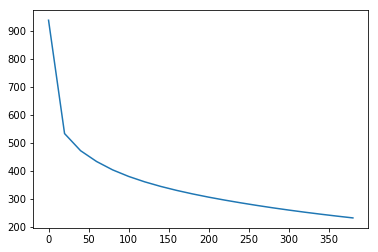

In [242]:
plt.plot(range(0,n*step,step), error)

**Further Resources**:
- [a whole course on randomized algorithms](http://www.cs.ubc.ca/~nickhar/W12/)

### More Details

Here is a process to calculate a truncated SVD, described in [Finding Structure with Randomness: Probabilistic Algorithms for Constructing Approximate Matrix Decompositions](https://arxiv.org/pdf/0909.4061.pdf) and [summarized in this blog post](https://research.fb.com/fast-randomized-svd/):

1\. Compute an approximation to the range of $A$. That is, we want $Q$ with $r$ orthonormal columns such that $$A \approx QQ^TA$$


2\. Construct $B = Q^T A$, which is small ($r\times n$)


3\. Compute the SVD of $B$ by standard methods (fast since $B$ is smaller than $A$), $B = S\,\Sigma V^T$

4\. Since $$ A \approx Q Q^T A = Q (S\,\Sigma V^T)$$ if we set $U = QS$, then we have a low rank approximation $A \approx U \Sigma V^T$.

#### So how do we find $Q$ (in step 1)?

To estimate the range of $A$, we can just take a bunch of random vectors $w_i$, evaluate the subspace formed by $Aw_i$.  We can form a matrix $W$ with the $w_i$ as it's columns.  Now, we take the QR decomposition of $AW = QR$, then the columns of $Q$ form an orthonormal basis for $AW$, which is the range of $A$.

Since the matrix $AW$ of the product has far more rows than columns and therefore, approximately, orthonormal columns. This is simple probability - with lots of rows, and few columns, it's unlikely that the columns are linearly dependent.

#### The QR Decomposition

We will be learning about the QR decomposition **in depth** later on.  For now, you just need to know that $A = QR$, where $Q$ consists of orthonormal columns, and $R$ is upper triangular.  Trefethen says that the QR decomposition is the most important idea in numerical linear algebra!  We will definitely be returning to it.

#### How should we choose $r$?

Suppose our matrix has 100 columns, and we want 5 columns in U and V. To be safe, we should project our matrix onto an orthogonal basis with a few more rows and columns than 5 (let's use 15).  At the end, we will just grab the first 5 columns of U and V

So even although our projection was only approximate, by making it a bit bigger than we need, we can make up for the loss of accuracy (since we're only taking a subset later). 

In [175]:
%time u, s, v = decomposition.randomized_svd(vectors, 5)

CPU times: user 144 ms, sys: 8 ms, total: 152 ms
Wall time: 154 ms


In [176]:
%time u, s, v = decomposition.randomized_svd(vectors.todense(), 5)

CPU times: user 2.38 s, sys: 592 ms, total: 2.97 s
Wall time: 2.96 s


## End